# Graph

## 환경설정

In [30]:
!wget -q https://dlcdn.apache.org/spark/spark-3.2.4/spark-3.2.4-bin-hadoop3.2.tgz
!tar xf spark-3.2.4-bin-hadoop3.2.tgz
!pip install -q findspark graphframes

In [31]:
import findspark
findspark.init("/content/spark-3.2.4-bin-hadoop3.2")

In [32]:
from pyspark.sql import SparkSession
spark = SparkSession.builder\
            .config("spark.driver.memory", "8g")\
            .config("spark.jars.packages", "graphframes:graphframes:0.8.2-spark3.2-s_2.12")\
            .getOrCreate()
sc = spark.sparkContext

In [33]:
from google.colab import drive
drive.mount('/gdrive')
gpath = '/gdrive/MyDrive/data/'

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).


In [34]:
from pyspark.sql.functions import col, lit, when
from graphframes import *
import networkx as nx
import matplotlib.pylab as plt

## Pagerank

In [35]:
# Create a Vertex DataFrame with unique ID column "id"
v = spark.createDataFrame([
  ("a", "Alice", 34),
  ("b", "Bob", 36),
  ("c", "Charlie", 30),
], ["id", "name", "age"])

# Create an Edge DataFrame with "src" and "dst" columns
e = spark.createDataFrame([
  ("a", "b", "friend"),
  ("b", "c", "follow"),
  ("c", "b", "follow"),
], ["src", "dst", "relationship"])

# Create a GraphFrame
g = GraphFrame(v, e)

In [36]:
def PlotGraph(edge_list, figsize_=(8,5)):
    Gplot=nx.DiGraph()
    for row in edge_list.select('src','dst').collect():
        Gplot.add_edge(row['src'],row['dst'])

    plt.figure(figsize=figsize_)
    plt.subplot(121)
    nx.draw(Gplot, with_labels=True, font_weight='bold')

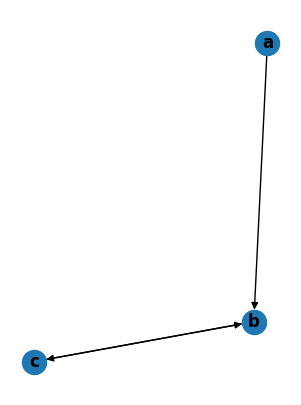

In [37]:
PlotGraph(g.edges)

In [38]:
g.inDegrees.show()

+---+--------+
| id|inDegree|
+---+--------+
|  b|       2|
|  c|       1|
+---+--------+



In [39]:
g.outDegrees.show()

+---+---------+
| id|outDegree|
+---+---------+
|  a|        1|
|  c|        1|
|  b|        1|
+---+---------+



In [40]:
# Run PageRank algorithm, and show results.
results = g.pageRank(resetProbability=0.15, maxIter=5)
results.vertices.select("id", "pagerank").show()

+---+-------------------+
| id|           pagerank|
+---+-------------------+
|  c|       1.1866759375|
|  b| 1.6633240624999999|
|  a|0.15000000000000002|
+---+-------------------+



## 예제 : Citation network

In [41]:
# load data
nodeDF = spark.read.option('header', 'false') \
                .csv(gpath+'citeseer.node_labels') \
                .toDF("id", "label")

nodeDF.show()

+---+-----+
| id|label|
+---+-----+
|  1|    2|
|  2|    2|
|  3|    5|
|  4|    6|
|  5|    2|
|  6|    2|
|  7|    6|
|  8|    2|
|  9|    2|
| 10|    4|
| 11|    5|
| 12|    6|
| 13|    5|
| 14|    2|
| 15|    2|
| 16|    4|
| 17|    5|
| 18|    5|
| 19|    6|
| 20|    6|
+---+-----+
only showing top 20 rows



In [ ]:
edgeDF = spark.read.option('header', 'false') \
                .csv(gpath+'citeseer.edges') \
                .toDF("src", "dst", "_")

edgeDF.show()

+---+----+---+
|src| dst|  _|
+---+----+---+
|  1| 870|  1|
|  2| 598|  1|
|  2|2207|  1|
|  2|2887|  1|
|  2| 670|  1|
|  2| 327|  1|
|  2| 795|  1|
|  3|2090|  1|
|  3| 712|  1|
|  3|2929|  1|
|  3|2907|  1|
|  3|2039|  1|
|  3|  18|  1|
|  3|1560|  1|
|  4| 452|  1|
|  4| 930|  1|
|  5| 627|  1|
|  5| 774|  1|
|  6| 642|  1|
|  6| 443|  1|
+---+----+---+
only showing top 20 rows



In [ ]:
v = nodeDF.select('id')
e = edgeDF.select('src', 'dst')

# Create a GraphFrame
g = GraphFrame(v, e)

In [ ]:
g.inDegrees.sort(col("inDegree").desc()).show(5)

+----+--------+
|  id|inDegree|
+----+--------+
|2907|      74|
| 870|      43|
|3222|      27|
|2686|      23|
|2039|      19|
+----+--------+
only showing top 5 rows



In [ ]:
g.outDegrees.sort(col("outDegree").desc()).show(5)

+----+---------+
|  id|outDegree|
+----+---------+
| 181|       34|
|2907|       25|
| 190|       21|
|1177|       20|
|2041|       20|
+----+---------+
only showing top 5 rows



In [ ]:
results = g.pageRank(resetProbability=0.15, maxIter=5)
results.vertices.select("id", "pagerank").sort(col("pagerank").desc()).show(5)

+----+------------------+
|  id|          pagerank|
+----+------------------+
|2907|29.298695282358278|
| 870|17.272874553304444|
|3066|15.316733967038537|
|3222|12.365484768042466|
| 924| 10.54443112266911|
+----+------------------+
only showing top 5 rows



## 도전과제 : dolphins.csv

In [ ]:
filename = 'dolphins.csv'

# load data
dolphinDF = spark.read.option('header', 'false') \
                .csv(gpath+filename) \
                .toDF("src", "_", "dst","_")

dolphinDF.show(5)

+-------+---+-------+---+
|    src|  _|    dst|  _|
+-------+---+-------+---+
| Double|  0|    CCL|  0|
|    CCL|  0| Double|  0|
|Feather|  0|   DN16|  0|
|   DN16|  0|Feather|  0|
|Feather|  0|   DN21|  0|
+-------+---+-------+---+
only showing top 5 rows



In [ ]:
dolphin_v = dolphinDF.select('src').distinct().withColumnRenamed('src','id')
dolphin_e = dolphinDF.select('src', 'dst')

# Create a GraphFrame
dolphin_g = GraphFrame(dolphin_v, dolphin_e)

In [ ]:
dolphin_g.inDegrees.sort(col("inDegree").desc()).show(5)

+-------+--------+
|     id|inDegree|
+-------+--------+
|   Grin|      12|
|Topless|      11|
|    SN4|      11|
|Trigger|      10|
|  Scabs|      10|
+-------+--------+
only showing top 5 rows



In [ ]:
dolphin_g.outDegrees.sort(col("outDegree").desc()).show(5)

+-------+---------+
|     id|outDegree|
+-------+---------+
|   Grin|       12|
|Topless|       11|
|    SN4|       11|
|Trigger|       10|
|  Scabs|       10|
+-------+---------+
only showing top 5 rows



In [ ]:
dolphin_pagerank = dolphin_g.pageRank(resetProbability=0.15, maxIter=5)
dolphin_pagerank.vertices.select("id", "pagerank").sort(col("pagerank").desc()).show(5)

+-------+------------------+
|     id|          pagerank|
+-------+------------------+
|    Jet| 2.031840806564766|
|Trigger|2.0135618997400933|
|   Grin|1.9986656805199525|
|    Web|1.8915907492097588|
|    SN4|1.8492657968459802|
+-------+------------------+
only showing top 5 rows



In [ ]:
dolphin_pagerank = dolphin_g.pageRank(resetProbability=0.15, maxIter=30)
dolphin_pagerank.vertices.select("id", "pagerank").sort(col("pagerank").desc()).show(5)

+-------+------------------+
|     id|          pagerank|
+-------+------------------+
|   Grin|1.9928965934138434|
|    Jet|1.9672521017662636|
|Trigger| 1.940504592744019|
|    Web| 1.866022190860047|
|    SN4| 1.852217650036542|
+-------+------------------+
only showing top 5 rows



## 도전과제 : lesmis.csv

In [ ]:
filename = 'lesmis.csv'
# load data
lesmisDF = spark.read.option('header', 'false') \
                .csv(gpath+filename) \
                .toDF("src", "_", "dst","_")

lesmisDF.show(5)

+--------------+---+--------------+---+
|           src|  _|           dst|  _|
+--------------+---+--------------+---+
|      Napoleon|  1|        Myriel|  0|
|        Myriel|  1|      Napoleon|  0|
|MlleBaptistine|  8|        Myriel|  0|
|        Myriel|  8|MlleBaptistine|  0|
|   MmeMagloire| 10|        Myriel|  0|
+--------------+---+--------------+---+
only showing top 5 rows



In [ ]:
lesmis_v = lesmisDF.select('src').distinct().withColumnRenamed('src','id')
lesmis_e = lesmisDF.select('src', 'dst')

# Create a GraphFrame
lesmis_g = GraphFrame(lesmis_v, lesmis_e)

In [ ]:
lesmis_g.inDegrees.sort(col("inDegree").desc()).show(5)

+----------+--------+
|        id|inDegree|
+----------+--------+
|   Valjean|      36|
|  Gavroche|      22|
|    Marius|      19|
|    Javert|      17|
|Thenardier|      16|
+----------+--------+
only showing top 5 rows



In [ ]:
lesmis_g.outDegrees.sort(col("outDegree").desc()).show(5)

+----------+---------+
|        id|outDegree|
+----------+---------+
|   Valjean|       36|
|  Gavroche|       22|
|    Marius|       19|
|    Javert|       17|
|Thenardier|       16|
+----------+---------+
only showing top 5 rows



In [ ]:
lesmis_pagerank = lesmis_g.pageRank(resetProbability=0.15, maxIter=5)
lesmis_pagerank.vertices.select("id", "pagerank").sort(col("pagerank").desc()).show(5)

+--------+------------------+
|      id|          pagerank|
+--------+------------------+
| Valjean| 5.958067912136485|
|  Myriel| 4.333748709807696|
|Gavroche| 2.696503213165988|
|  Javert|2.3491232884132773|
|  Marius|2.3377786249362966|
+--------+------------------+
only showing top 5 rows



In [ ]:
lesmis_pagerank = lesmis_g.pageRank(resetProbability=0.15, maxIter=30)
lesmis_pagerank.vertices.select("id", "pagerank").sort(col("pagerank").desc()).show(5)

+--------+------------------+
|      id|          pagerank|
+--------+------------------+
| Valjean| 5.808307933340444|
|  Myriel| 3.294119438571231|
|Gavroche| 2.753967538883903|
|  Marius| 2.378828856602894|
|  Javert|2.3333096695950277|
+--------+------------------+
only showing top 5 rows

